In [5]:
# @hidden_cell
# The project token is an authorization token that is used to access project resources like data sources, connections, and used by platform APIs.
from project_lib import Project
project = Project(project_id='33c6f32e-9af7-4146-82e6-2279bc456dcd', project_access_token='p-ba26089b0b888076af9716131e79ff3c39e29566')
pc = project.project_context


# Insurance Fraud Claim Detection

In [13]:
!pip install imblearn
!pip install  mlxtend

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from mlxtend.plotting import plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, accuracy_score, recall_score, roc_curve, precision_recall_curve, auc
from sklearn.tree import DecisionTreeClassifier
from watson_machine_learning_client import WatsonMachineLearningAPIClient
import warnings


In [11]:
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials_1 = {
  "apikey": "3DKtmSLDP_D0-KOMQPY5xHKotZTAvFWqeVXcVGJ_PBSv",
  "iam_apikey_description": "Auto-generated for key cba5a619-773c-42c2-adc3-dbb43fabb3fd",
  "iam_apikey_name": "wdp-writer",
  "iam_role_crn": "crn:v1:bluemix:public:iam::::serviceRole:Writer",
  "iam_serviceid_crn": "crn:v1:bluemix:public:iam-identity::a/aaa4a2bd008d43dd94c85b19f902fd61::serviceid:ServiceId-ece47b9c-a970-4349-9797-e417149b5541",
  "instance_id": "e79ff7f2-be61-4a68-9d1d-8d0e5d18f563",
  "url": "https://eu-gb.ml.cloud.ibm.com"
}
client = WatsonMachineLearningAPIClient(credentials_1)

In [ ]:
np.random.seed(1)
warnings.filterwarnings("ignore")
# @hidden_cell
# The following code contains the credentials for a file in your IBM Cloud Object Storage.
# You might want to remove those credentials before you share your notebook.
credentials_1 = {
    'IAM_SERVICE_ID': 'iam-ServiceId-96eadd32-c0f4-4665-b905-134717b6ba99',
    'IBM_API_KEY_ID': 'SjDQvbpJ7uXD7SWKOrXNETs5wSpKf162px0M4fGDi_BG',
    'ENDPOINT': 'https://s3.eu-geo.objectstorage.service.networklayer.com',
    'IBM_AUTH_ENDPOINT': 'https://iam.cloud.ibm.com/oidc/token',
    'BUCKET': 'watsonworkshop-donotdelete-pr-rjns2kwdwqmhpp',
    'FILE': 'insurance_claims.csv'
}
data = pd.read_csv(credentials_1["FILE"])

drop_columns = ["_c39", "auto_model", "policy_bind_date", "policy_state", "incident_date",
               "incident_state", "incident_city", "incident_location", "policy_csl"]

data = data.drop(drop_columns, axis=1)

new_response = []
response = data.iloc[:, -1]
for i in range(len(response)):
    new_response.append(1 if response[i]=='Y' else 0)

data["fraud_reported"] = pd.Series(new_response)

We will be dropping insignificant features like: 

- policy_bind_date
- policy_state
- incident_date
- auto_model
- _c39
- policy_csl

# Performing initial EDA.

Text(0, 0.5, 'Number of customers')

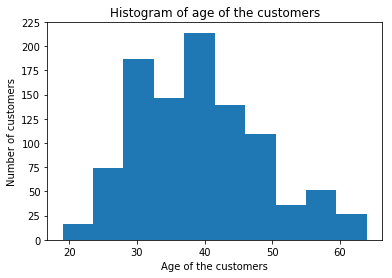

In [16]:
plt.hist(data.age)
plt.title("Histogram of age of the customers")
plt.xlabel("Age of the customers")
plt.ylabel("Number of customers")

Text(0, 0.5, 'Number of customers')

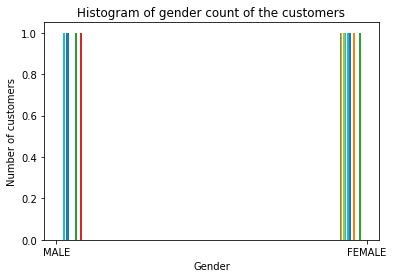

In [17]:
plt.hist(data.insured_sex)
plt.title("Histogram of gender count of the customers")
plt.xlabel("Gender")
plt.ylabel("Number of customers")

- We can see that male and female are almost in the same proportion.

Text(0, 0.5, 'Number of responses')

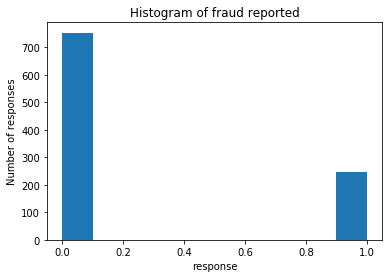

In [18]:
plt.hist(data.fraud_reported)
plt.title("Histogram of fraud reported")
plt.xlabel("response")
plt.ylabel("Number of responses")

- We can also see that there is a significant class imbalance, we will be using SMOTE, Synthetic Minority Oversampling Technique to add additional minority class data points.

In [34]:
matrix = np.triu(data.corr())
try:
    sns.heatmap(data.corr(),annot = True,cmap= 'coolwarm' ,linewidths=3, linecolor='black', square=True , mask=matrix)
    plt.show()
except:
    pass


In [25]:
predictors = data.iloc[:,:-1]
response = data.iloc[:, -1]

# new_response = []

# for i in range(len(response)):
#     new_response.append(1 if response[i]=='Y' else 0)
    
# response = pd.Series(new_response)

categorical_data = predictors.select_dtypes(exclude="number")
categorical_predictors = categorical_data.columns

predictors = predictors.drop(categorical_predictors, axis=1)

- Since most of our data is categorical we have two options, assign a integer value to each level of the categorical variable or one-hot encode these categorical variables. 

- One major drawback of assigning integer value to each level is that it adds additional charecteristics to the data. For example let's say we have a variable with levels as BMW, Mazda, Mercedes and Subaru and we are assigning 0, 1, 2 and 3 integer values to them respectively. When we apply any model the model considers these values as continuous and assumes an unwanted hierarchy like BMQ < Mazda < Mercedes < Subaru, which might not be the case at all.

- Hence we go with one hot encoding of categorical variables. 

In [26]:
one_hot_data = pd.get_dummies(categorical_data)
predictors = predictors.join(one_hot_data)

predictor_columns = predictors.columns
response_columns = response

predictors_train, predictors_test, response_train, response_test = train_test_split(predictors,
                                                                                    response,
                                                                                    test_size=0.3)

- Since we have class imbalance in the data, we perform minority class oversampling using SMOTE, Synthetic Minority Oversampling Technique, which uses K nearest neighbors to come up with new samples in the minority class.

In [27]:
sm = SMOTE(random_state=24)
predictors, response = sm.fit_resample(predictors_train, response_train)

predictors_train = pd.DataFrame(predictors, columns=predictor_columns)
response_train = pd.Series(response)

model_preds = {}

# Logistic Regression

*****************************************
Results on testing data:
*****************************************
Accuracy = 0.5566666666666666
Precision = 0.6
Recall = 0.3221476510067114

AUC value = 0.5551135606026935


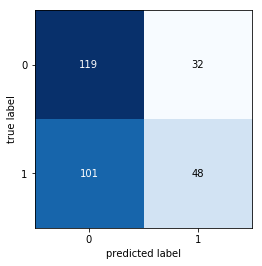

In [28]:
model = LogisticRegression()
model.fit(predictors_train, response_train)
predictions_test = model.predict(predictors_test)
predictions_train = model.predict(predictors_train)

conf_matrix = confusion_matrix(predictions_test, response_test)
plot_confusion_matrix(conf_matrix)

precision = precision_score(predictions_test, response_test)
recall = recall_score(predictions_test, response_test)

print("*****************************************")
print("Results on testing data:")
print("*****************************************")
print("Accuracy = "+str(accuracy_score(predictions_test, response_test)))
print("Precision = "+str(precision))
print("Recall = "+str(recall))

tpr, fpr, threshold = roc_curve(predictions_test, response_test, pos_label=1)
model_preds["Logistic Regression"] = [tpr, fpr]
print()
print("AUC value = "+str(auc(tpr, fpr)))

# K Nearest Neighbors

*****************************************
Results on testing data:
*****************************************
Accuracy = 0.54
Precision = 0.45
Recall = 0.27692307692307694

AUC value = 0.5090497737556561


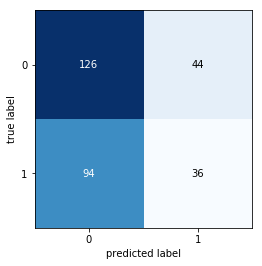

In [29]:
knn = KNeighborsClassifier()
knn.fit(predictors_train, response_train)

predictions_train = knn.predict(predictors_train)
predictions_test = knn.predict(predictors_test)

conf_matrix = confusion_matrix(predictions_test, response_test)
plot_confusion_matrix(conf_matrix)

precision = precision_score(predictions_test, response_test)
recall = recall_score(predictions_test, response_test)

print("*****************************************")
print("Results on testing data:")
print("*****************************************")
print("Accuracy = "+str(accuracy_score(predictions_test, response_test)))
print("Precision = "+str(precision))
print("Recall = "+str(recall))

tpr, fpr, threshold = roc_curve(predictions_test, response_test, pos_label=1)
model_preds["K Nearest Neighbor"] = [tpr, fpr]
print()
print("AUC value = "+str(auc(tpr, fpr)))

# Decision Trees

*****************************************
Results on testing data:
*****************************************
Accuracy = 0.825
Precision = 0.8802395209580839
Recall = 0.8032786885245902

AUC value = 0.8286466435323679


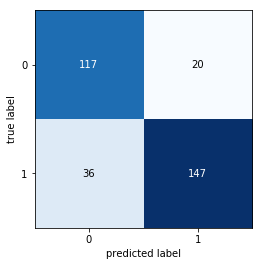

In [30]:
## Since it has a lot of categorical variables and the dataset is also not huge we 
## will use decision trees to get more accuracy.

predictors_train, predictors_test, response_train, response_test = train_test_split(predictors,response,test_size=0.3)

tree = DecisionTreeClassifier()
tree.fit(predictors_train, response_train)
predictions_test = tree.predict(predictors_test)
predictions_train = tree.predict(predictors_train)

conf_matrix = confusion_matrix(predictions_test, response_test)
plot_confusion_matrix(conf_matrix)

precision = precision_score(predictions_test, response_test)
recall = recall_score(predictions_test, response_test)

print("*****************************************")
print("Results on testing data:")
print("*****************************************")
print("Accuracy = "+str(accuracy_score(predictions_test, response_test)))
print("Precision = "+str(precision))
print("Recall = "+str(recall))

tpr, fpr, threshold = roc_curve(predictions_test, response_test, pos_label=1)
model_preds["Decision Tree"] = [tpr, fpr]
print()
print("AUC value = "+str(auc(tpr, fpr)))

# Random Forest Classifier

*****************************************
Results on testing data:
*****************************************
Accuracy = 0.878125
Precision = 0.8802395209580839
Recall = 0.8855421686746988

AUC value = 0.8778360194022844


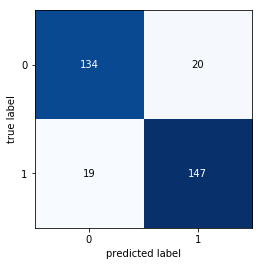

In [31]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()
random_forest.fit(predictors_train, response_train)
predictions_test = random_forest.predict(predictors_test)
predictions_train = random_forest.predict(predictors_train)

conf_matrix = confusion_matrix(predictions_test, response_test)
plot_confusion_matrix(conf_matrix)

precision = precision_score(predictions_test, response_test)
recall = recall_score(predictions_test, response_test)

print("*****************************************")
print("Results on testing data:")
print("*****************************************")
print("Accuracy = "+str(accuracy_score(predictions_test, response_test)))
print("Precision = "+str(precision))
print("Recall = "+str(recall))

tpr, fpr, threshold = roc_curve(predictions_test, response_test, pos_label=1)
model_preds["Random Forest"] = [tpr, fpr]
print()
print("AUC value = "+str(auc(tpr, fpr)))

# Linear Discriminant Analysis

*****************************************
Results on testing data:
*****************************************
Accuracy = 0.89375
Precision = 0.8862275449101796
Recall = 0.9079754601226994

AUC value = 0.8934781759212224


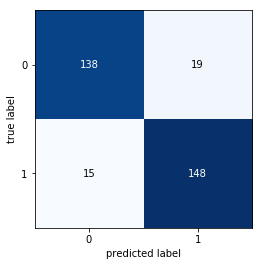

In [32]:
lda = LinearDiscriminantAnalysis()
lda.fit(predictors_train, response_train)
predictions_test = lda.predict(predictors_test)
predictions_train = lda.predict(predictors_train)

conf_matrix = confusion_matrix(predictions_test, response_test)
plot_confusion_matrix(conf_matrix)

precision = precision_score(predictions_test, response_test)
recall = recall_score(predictions_test, response_test)

print("*****************************************")
print("Results on testing data:")
print("*****************************************")
print("Accuracy = "+str(accuracy_score(predictions_test, response_test)))
print("Precision = "+str(precision_score(predictions_test, response_test)))
print("Recall = "+str(recall_score(predictions_test, response_test)))

tpr, fpr, threshold = roc_curve(predictions_test, response_test, pos_label=1)
model_preds["Linear Discriminant Analysis"] = [tpr, fpr]
print()
print("AUC value = "+str(auc(tpr, fpr)))

# Receiving Operator Charecteristic

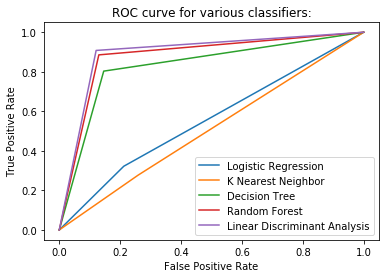

In [33]:
plt.title("ROC curve for various classifiers:")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")

for key, value in model_preds.items():
    model_list = model_preds[key]
    plt.plot(model_list[0], model_list[1], label=key)
    plt.legend()
plt.show()

- As we can see from the above ROC curves and results LDA is performing well when compared to all the classifiers.
- KNN is performing the worst out of all the classifiers.
- I was hoping to get better results with Random Forests but with this size of the data I am not surprised with this result. 

In [ ]:
model_props = { client.repository.ModelMetaNames.AUTHOR_NAME:"bharat chandra",
               client.repository.ModelMetaNames.AUTHOR_EMAIL:"bharat.chandra200@gmail.com",
    client.repository.ModelMetaNames.NAME:"df"
}

In [ ]:
model_artifact = client.repository.store_model(model,meta_props=model_props)

In [32]:
published_model_uid = client.repository.get_model_uid(model_artifact)

In [33]:
published_model_uid

'8abf8d50-c975-4424-b682-121548914a7b'

In [35]:
deployment = client.deployments.create(published_model_uid,name="MLmodel")



#######################################################################################

Synchronous deployment creation for uid: '8abf8d50-c975-4424-b682-121548914a7b' started

#######################################################################################


INITIALIZING
DEPLOY_SUCCESS


------------------------------------------------------------------------------------------------
Successfully finished deployment creation, deployment_uid='03a70ef0-c03b-4d2d-85b0-255f0ec783c0'
------------------------------------------------------------------------------------------------




In [36]:
scoring_endpoint = client.deployments.get_scoring_url(deployment)

In [37]:
scoring_endpoint

'https://eu-gb.ml.cloud.ibm.com/v3/wml_instances/e79ff7f2-be61-4a68-9d1d-8d0e5d18f563/deployments/03a70ef0-c03b-4d2d-85b0-255f0ec783c0/online'